#ch08-How to Develop a DCGAN for Small Color Photographs
- [ch08-How to Develop a DCGAN for Small Color Photographs](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/) by [Jason Brownlee](https://machinelearningmastery.com/author/jasonb/) on Sept 1, 2020 in [Generative Adversarial Networks](https://machinelearningmastery.com/category/generative-adversarial-networks/)
- Revised by Ivan HP Lin (WIP-3)

Generative Adversarial Networks, or GANs, are an architecture for training generative models, such as deep convolutional neural networks for generating images.

Developing a GAN for generating images requires both a discriminator convolutional neural network model for classifying whether a given image is real or generated and a generator model that uses inverse convolutional layers to transform an input to a full two-dimensional image of pixel values.

It can be challenging to understand both how GANs work and how deep convolutional neural network models can be trained in a GAN architecture for image generation. A good starting point for beginners is to practice developing and using GANs on standard image datasets used in the field of computer vision, such as the CIFAR small object photograph dataset. Using small and well-understood datasets means that smaller models can be developed and trained quickly, allowing focus to be put on the model architecture and image generation process itself.

In this tutorial, you will discover how to develop a generative adversarial network with deep convolutional networks for generating small photographs of objects.

After completing this tutorial, you will know:

* How to define and train the standalone discriminator model for learning the difference between real and fake images.
* How to define the standalone generator model and train the composite generator and discriminator model.
* How to evaluate the performance of the GAN and use the final standalone generator model to generate new images.

#0.. Tutorial Overview


1. CIFAR-10 Small Object Photograph Dataset
2. How to Define and Train the Discriminator Model
3. How to Define and Use the Generator Model
4. How to Train the Generator Model
5. How to Evaluate GAN Model Performance
6. Complete Example of GAN for CIFAR-10
7. How to Use the Final Generator Model to Generate Images

In [1]:
## To know if it is runing on colab
import sys
import os
from datetime import date
from datetime import datetime
import pytz

IN_COLAB = 'google.colab' in sys.modules

if (IN_COLAB):
  from google.colab import drive
  drive.mount('/gdrive')
  PROJ_DIR='/gdrive/MyDrive/00_AI.Garden/01_Github/252_ML.tutorial/ML_Mastery/GAN/'
  FOLDER_MODEL = PROJ_DIR + 'models/'
  FOLDER_PLOT = PROJ_DIR + 'plots/'
else:
  PROJ_DIR='./'
  FOLDER_MODEL = PROJ_DIR + 'models/'
  FOLDER_PLOT = PROJ_DIR + 'plots/'

os.makedirs(FOLDER_MODEL, exist_ok=True)
os.makedirs(FOLDER_PLOT, exist_ok=True)
print(f'folder for models @ {FOLDER_MODEL}')
print(f'folder for plots @ {FOLDER_PLOT}')

tz = pytz.timezone('Asia/Taipei')
today = date.today()
now = datetime.now(tz)

# dd/mm/YY H:M:S
dateCode = now.strftime("%Y%m%d_%H%M")
dateCodePostfix = dateCode
print("dateCodePostfix =", dateCodePostfix)	
dateCodePrefix = 'gan.ch08_'
print("dateCodePrefix =", dateCodePrefix)	

Mounted at /gdrive
folder for models @ /gdrive/MyDrive/00_AI.Garden/01_Github/252_ML.tutorial/ML_Mastery/GAN/models/
folder for plots @ /gdrive/MyDrive/00_AI.Garden/01_Github/252_ML.tutorial/ML_Mastery/GAN/plots/
dateCodePostfix = 20220524_0116
dateCodePrefix = gan.ch08_


#1.. CIFAR-10 Small Object Photograph Dataset

CIFAR is an acronym that stands for the Canadian Institute For Advanced Research and the [CIFAR-10 dataset](https://en.wikipedia.org/wiki/CIFAR-10) was developed along with the CIFAR-100 dataset (covered in the next section) by researchers at the [CIFAR institute](https://www.cs.toronto.edu/~kriz/cifar.html).

The dataset is comprised of 60,000 $32×32$ pixel color photographs of objects from 10 classes, such as frogs, birds, cats, ships, airplanes, etc.

These are very small images, much smaller than a typical photograph, and the dataset is intended for computer vision research.

Keras provides access to the CIFAR10 dataset via the **```cifar10.load_dataset()```** function. It returns two tuples, 
1. one with the input and output elements for the standard training dataset, 
2. and another with the input and output elements for the standard test dataset.

The example below loads the dataset and summarizes the shape of the loaded dataset.

Note: the first time you load the dataset, Keras will automatically download a compressed version of the images and save them under your home directory in ***```~/.keras/datasets/```***. The download is fast as the dataset is only about 163 megabytes in its compressed form.

In [2]:
# example of loading the cifar10 dataset
from keras.datasets.cifar10 import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print(f'Train shape: [trainX.shape, trainy.shape] = [{trainX.shape}, {trainy.shape}]')
print(f'Test shape:  [testX.shape, testy.shape] =  [{testX.shape}, {testy.shape}]')

170508288/170498071 [==============================] - 2s 0us/step
Train shape: [trainX.shape, trainy.shape] = [(50000, 32, 32, 3), (50000, 1)]
Test shape:  [testX.shape, testy.shape] =  [(10000, 32, 32, 3), (10000, 1)]


The example below plots the first $49$ images from the training dataset in a $7$ x $7$ square

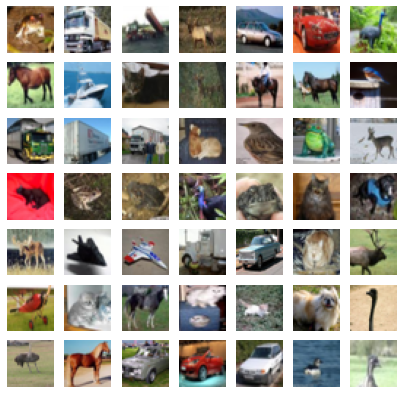

In [3]:
# example of loading and plotting the cifar10 dataset
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
pyplot.figure(figsize=(7,7))
for i in range(49):
	# define subplot
	pyplot.subplot(7, 7, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i])
pyplot.show()

The generator model ($G$) will learn how to generate new plausible photographs of objects using a discriminator that will try and distinguish between real images from the CIFAR10 training dataset and new images output by the generator model.

This is a non-trivial problem that requires modest generator and discriminator models that are probably most effectively trained on GPU hardware.

#2.. Define and Train the Discriminator Model ($D$)

The first step is to define the discriminator model.

The model must take a sample image from our dataset as input and output a classification prediction as to whether the sample is real or fake. This is a binary classification problem.

* **Inputs**: Image with three color channel and 32×32 pixels in size.
* **Outputs**: Binary classification, likelihood the sample is real (or fake).

The discriminator model has a normal convolutional layer followed by three convolutional layers using a stride of 2×2 to downsample the input image. The model has no [pooling layers](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) and a single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. The model is trained to minimize the [**binary cross entropy loss** function](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/), appropriate for binary classification.

We will use some best practices in defining the discriminator model, such as the use of **LeakyReLU** instead of [ReLU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/), using Dropout, and using the [Adam version of stochastic gradient descent](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) with a [learning rate](https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/) of 0.0002 and a momentum of 0.5.

The **```define_discriminator()```** function below defines the discriminator model and parametrizes the size of the input image.

In [4]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

The complete example is listed below.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

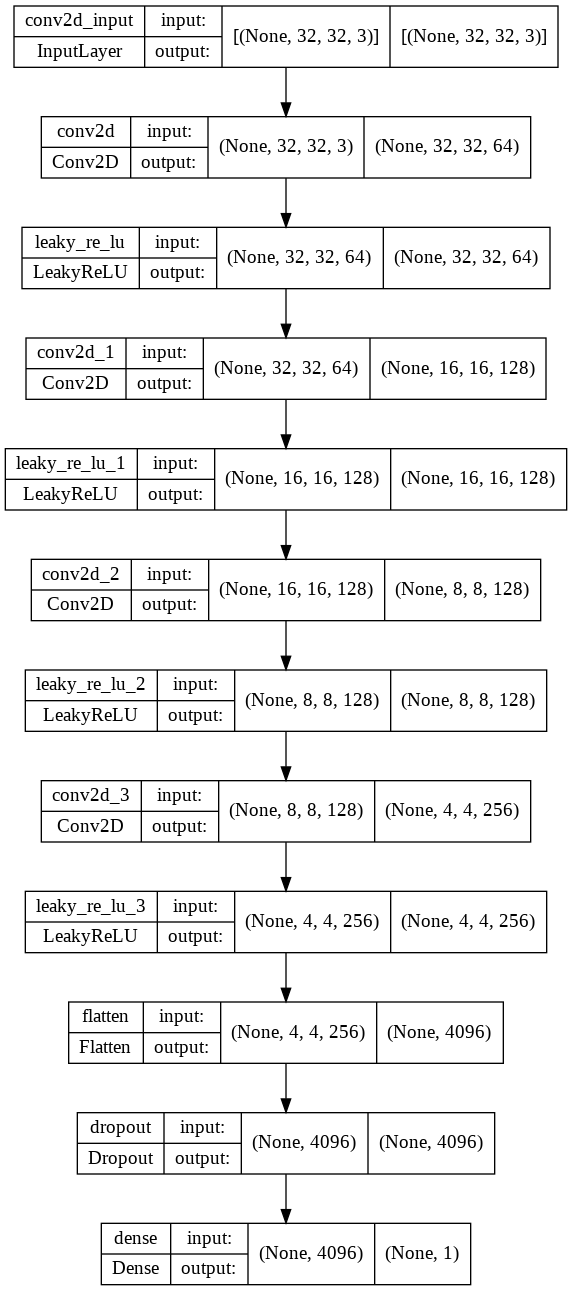

In [5]:
# example of defining the discriminator model
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

We can see that the aggressive 2×2 stride acts to down-sample the input image, first from 32×32 to 16×16, then to 8×8 and more before the model makes an output prediction.

This pattern is by design as we do not use pooling layers and use the large stride to achieve a similar downsampling effect. We will see a similar pattern, but in reverse in the generator model in the next section.

We could start training this model now with real examples with a class label of $1$ and randomly generate samples with a class label of $0$.

The development of these elements will be useful later, and it helps to see that the discriminator $(D)$ is just a normal neural network model for binary classification.

1.  we need a function to load and prepare the dataset of real images.  We will use the **```cifar.load_data()```** function to load the CIFAR-10 dataset and just use the input part of the training dataset as the real images.
```
...
# load cifar10 dataset
(trainX, _), (_, _) = load_data()
```
2. We must scale the pixel values from the range of unsigned integers in $[0,255]$ to the normalized range of $[-1,1]$.  The generator model ($G$) will generate images with pixel values in the range $[-1,1]$ as it will use the tanh activation function, a best practice.  It is also a good practice for the real images to be scaled to the same range.
```
...
# convert from unsigned ints to floats
X = trainX.astype('float32')
# scale from [0,255] to [-1,1]
X = (X - 127.5) / 127.5
```
3. The **```load_real_samples()```** function below implements the loading and scaling of real CIFAR-10 photographs.

In [6]:
# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

4. The model will be updated in batches, specifically with a collection of real samples and a collection of generated samples. On training, an **epoch** is defined as one pass through the entire training dataset.
  - We could systematically enumerate all samples in the training dataset, and that is a good approach, but ***good training via stochastic gradient descent requires that the training dataset be shuffled prior to each epoch***. A simpler approach is to select random samples of images from the training dataset.

5. The **```generate_real_samples()```** function below will take the training dataset as an argument and will select a random subsample of images; it will also return class labels for the sample, specifically a class label of $1$, to indicate real images.

In [7]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

6. Finally, we need to train the discriminator model ($D$).  This involves repeatedly retrieving samples of real images and samples of generated images and updating the model for a fixed number of iterations.
  - We will ignore the idea of epochs for now (e.g. complete passes through the training dataset) and fit the discriminator model for a fixed number of batches. The model will learn to discriminate between real and fake (randomly generated) images rapidly, therefore not many batches will be required before it learns to discriminate perfectly.
  - The **```train_discriminator()```** function implements this, using a batch size of 128 images, where 64 are real and 64 are fake each iteration.

7. We update the discriminator separately for real and fake examples so that we can calculate the accuracy of the model on each sample prior to the update. This gives insight into how the discriminator model is performing over time.

In [8]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

Tying all of this together, the complete example of training an instance of the discriminator model ($D$) on real and randomly generated (fake) images is listed below.

In [9]:
# example of training the discriminator model on real and random cifar10 images
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(32 * 32 * 3 * n_samples)
	# update to have the range [-1, 1]
	X = -1 + X * 2
	# reshape into a batch of color images
	X = X.reshape((n_samples, 32, 32, 3))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# train the discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print(f'D[epoch={(i+1):02d}] [acc_real, acc_fake] = [{real_acc:3.2f},{fake_acc:3.2f}]')

# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

D[epoch=01] [acc_real, acc_fake] = [0.58,0.02]
D[epoch=02] [acc_real, acc_fake] = [1.00,0.02]
D[epoch=03] [acc_real, acc_fake] = [1.00,0.14]
D[epoch=04] [acc_real, acc_fake] = [0.97,0.34]
D[epoch=05] [acc_real, acc_fake] = [0.98,0.64]
D[epoch=06] [acc_real, acc_fake] = [0.91,0.91]
D[epoch=07] [acc_real, acc_fake] = [0.95,1.00]
D[epoch=08] [acc_real, acc_fake] = [0.92,1.00]
D[epoch=09] [acc_real, acc_fake] = [0.94,1.00]
D[epoch=10] [acc_real, acc_fake] = [0.94,1.00]
D[epoch=11] [acc_real, acc_fake] = [0.92,1.00]
D[epoch=12] [acc_real, acc_fake] = [1.00,1.00]
D[epoch=13] [acc_real, acc_fake] = [0.98,1.00]
D[epoch=14] [acc_real, acc_fake] = [0.97,1.00]
D[epoch=15] [acc_real, acc_fake] = [0.97,1.00]
D[epoch=16] [acc_real, acc_fake] = [0.98,1.00]
D[epoch=17] [acc_real, acc_fake] = [1.00,1.00]
D[epoch=18] [acc_real, acc_fake] = [0.98,1.00]
D[epoch=19] [acc_real, acc_fake] = [1.00,1.00]
D[epoch=20] [acc_real, acc_fake] = [1.00,1.00]


#3.. Define and Use the Generator Model ($G$)

The generator model is responsible for creating new, fake, but plausible small photographs of objects.

It does this by taking a point from the latent space as input and outputting a square color image.

The latent space is an arbitrarily defined vector space of [Gaussian-distributed values](https://machinelearningmastery.com/statistical-data-distributions/), e.g. 100 dimensions. It has no meaning, but by drawing points from this space randomly and providing them to the generator model during training, the generator model will assign meaning to the latent points and, in turn, the latent space, until, at the end of training, the latent vector space represents a compressed representation of the output space, CIFAR-10 images, that only the generator knows how to turn into plausible CIFAR-10 images.

* **Inputs**: Point in latent space, e.g. a 100-element vector of Gaussian random numbers.
* **Outputs**: Two-dimensional square color image (3 channels) of 32 x 32 pixels with pixel values in [-1,1].

Developing a generator model requires that we transform a vector from the latent space with, 100 dimensions to a 2D array with $32$ x $32$ x $3$, or $3,072$ values.

There are a number of ways to achieve this, but there is one approach that has proven effective on deep convolutional generative adversarial networks. It involves two main elements.

1. The first is a Dense layer as the first hidden layer that has enough nodes to represent a low-resolution version of the output image. Specifically, an image half the size (one quarter the area) of the output image would be 16x16x3, or 768 nodes, and an image one quarter the size (one eighth the area) would be 8 x 8 x 3, or 192 nodes.
  - With some experimentation, I have found that a smaller low-resolution version of the image works better. Therefore, we will use 4 x 4 x 3, or 48 nodes.

  We don’t just want one low-resolution version of the image; we want many parallel versions or interpretations of the input. This is a [pattern in convolutional neural networks](https://machinelearningmastery.com/review-of-architectural-innovations-for-convolutional-neural-networks-for-image-classification/) where we have many parallel filters resulting in multiple parallel activation maps, called **feature maps**, with different interpretations of the input. We want the same thing in reverse: many parallel versions of our output with different learned features that can be collapsed in the output layer into a final image. The model needs space to invent, create, or generate.

  Therefore, the first hidden layer, the Dense, needs enough nodes for multiple versions of our output image, such as 256.
```
# foundation for 4x4 image
n_nodes = 256 * 4 * 4
model.add(Dense(n_nodes, input_dim=latent_dim))
model.add(LeakyReLU(alpha=0.2))
```

  The activations from these nodes can then be reshaped into something image-like to pass into a convolutional layer, such as 256 different 4 x 4 feature maps.
```
model.add(Reshape((4, 4, 256)))  
```

2. The next major architectural innovation involves upsampling the low-resolution image to a higher resolution version of the image.

  There are two common ways to do this upsampling process, sometimes called deconvolution.

  One way is to use an ***UpSampling2D*** layer (like a reverse [pooling layer](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/)) followed by a normal **Conv2D** layer. The other and perhaps more modern way is to combine these two operations into a single layer, called a **```Conv2DTranspose```**. We will use this latter approach for our generator.

  The **```Conv2DTranspose```** layer can be configured with a [stride of (2×2)](https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/) that will quadruple the area of the input feature maps (double their width and height dimensions). It is also good practice to use a kernel size that is a factor of the stride (e.g. double) to [avoid a checkerboard pattern](https://distill.pub/2016/deconv-checkerboard/) that can sometimes be observed when upsampling.
```
# upsample to 8x8
model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
model.add(LeakyReLU(alpha=0.2))
```

This can be repeated two more times to arrive at our required 32 x 32 output image.

Again, we will use the ***LeakyReLU*** with a default slope of 0.2, reported as a best practice when training GAN models.

The output layer of the model is a **Conv2D** with three filters for the three required channels and a kernel size of $3$×$3$ and ‘same‘ padding, designed to create a single feature map and preserve its dimensions at $32$ x $32$ x $34$ pixels. A $tanh()$ activation is used to ensure output values are in the desired range of $[-1,1]$, a current best practice.

The **```define_generator()```** function below implements this and defines the generator model.

In [10]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

We can summarize the model to help better understand the input and output shapes.

The complete example is listed below.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

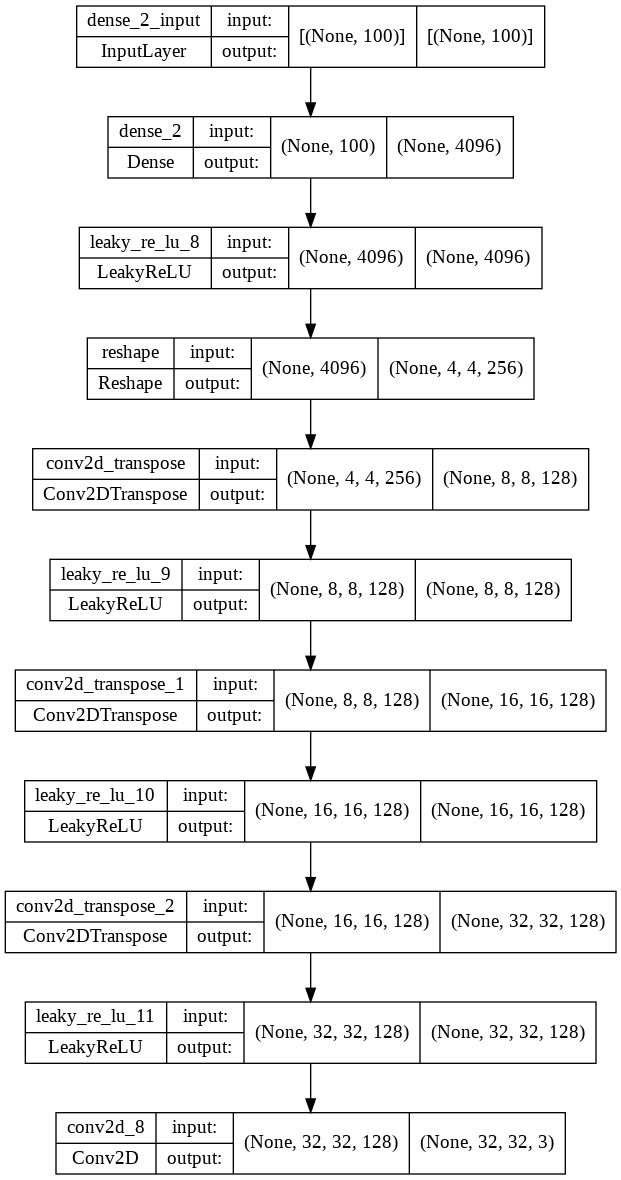

In [11]:
# example of defining the generator model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

We can see that, as designed, the first hidden layer has $4,096$ parameters or $256$ x $4$ x $4$, the activations of which are reshaped into $256$ $4$ x $4$ feature maps. The feature maps are then upscaled via the three ```Conv2DTranspose``` layers to the desired output shape of 32 x 32, until the output layer where three filter maps (channels) are created.

Now to generate new points in the latent space. We can achieve this by calling the [randn() NumPy function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randn.html) for generating [arrays of random numbers](https://machinelearningmastery.com/how-to-generate-random-numbers-in-python/) drawn from a standard Gaussian.

The array of random numbers can then be reshaped into samples, that is n rows with $100$ elements per row. The **```generate_latent_points()```** function below implements this and generates the desired number of points in the latent space that can be used as input to the generator model.

In [12]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

Next, we can use the generated points as input to the generator model to generate new samples, then plot the samples.

We can update the **```generate_fake_samples()```** function from the previous section to take the generator model as an argument and use it to generate the desired number of samples by first calling the **```generate_latent_points()```** function to generate the required number of points in latent space as input to the model.

The updated **```generate_fake_samples()```** function is listed below and returns both the generated samples and the associated class labels.

In [13]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

We can then plot the generated samples as we did the real CIFAR-10 examples in the first section by calling the **$imshow()$** function.

The complete example of generating new CIFAR-10 images with the untrained generator model is listed below.

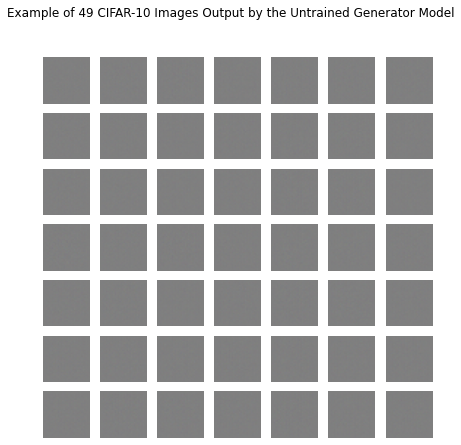

In [14]:
# example of defining and using the generator model
from numpy import zeros
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from matplotlib import pyplot

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 49
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the generated samples
pyplot.figure(figsize=(7,7))
for i in range(n_samples):
	# define subplot
	pyplot.subplot(7, 7, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i])
# show the figure
pyplot.suptitle('Example of 49 CIFAR-10 Images Output by the Untrained Generator Model')
pyplot.show()

#4.. Train the Generator Model ($G$)

**The weights in the generator model are updated based on the performance of the discriminator model.**

When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

This defines the zero-sum or adversarial relationship between these two models.

There may be many ways to implement this using the Keras API, but perhaps the simplest approach is to create a new model that combines the generator and discriminator models.

**A new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.**

To be clear, we are not talking about a new third model, just a new logical model that uses the already-defined layers and weights from the standalone generator and discriminator models.

**Only the discriminator is concerned with distinguishing between real and fake examples, therefore the discriminator model can be trained in a standalone manner** 

**The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.**



When training the generator via this logical GAN model, there is one more important change. **We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class $1$).**

**Why would we want to do this?**

We can imagine that the discriminator will then classify the generated samples as not real (class 0). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating good fake samples.

Let’s make this concrete.

* **Inputs**: Point in latent space, e.g. a $100$-element vector of Gaussian random numbers.
* **Outputs**: Binary classification, likelihood the sample is real (or fake).

The **```define_gan()```** function below takes as arguments the already-defined generator and discriminator models and creates the new, logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model.

The GAN model then uses the same **binary cross entropy loss** function as the discriminator and the efficient [Adam version of stochastic gradient descent](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) with the learning rate of 0.0002 and momentum of 0.5, recommended when training deep convolutional GANs.

In [15]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

The trainable property impacts the model after it is compiled. The discriminator model was compiled with trainable layers, therefore the model weights in those layers will be updated when the standalone model is updated via calls to the **```train_on_batch()```** function.

The discriminator model was then marked as not trainable, added to the GAN model, and compiled. In this model, the model weights of the discriminator model are not trainable and cannot be changed when the GAN model is updated via calls to the **'''train_on_batch()'''** function. This change in the trainable property does not impact the training of the standalone discriminator model.

This behavior is described in the Keras API documentation here:
  - [How can I “freeze” Keras layers?](https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers)
  
The complete example of creating the discriminator, generator and composite model is listed below.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


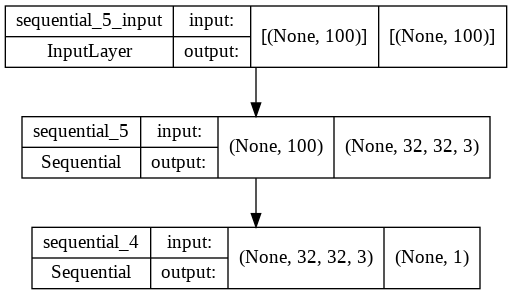

In [16]:
# demonstrate creating the three models in the gan
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

Training the composite model involves generating a batch worth of points in the latent space via the **```generate_latent_points()```** function in the previous section, and class=$1$ labels and calling the **```train_on_batch()```** function.

The **```train_gan()```** function below demonstrates this, although it is pretty simple as only the generator will be updated each epoch, leaving the discriminator with default model weights.

In [17]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=200, n_batch=128):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

We first update the discriminator model with real and fake samples, then update the generator via the composite model.

* This requires combining elements from the **```train_discriminator()```** function defined in the discriminator section above and the **```train_gan()```** function defined above. It also requires that we enumerate over both epochs and batches within in an epoch.

The complete train function for updating the discriminator model and the generator (via the composite model) is listed below.

There are a few things to note in this model training function.

1. First, the number of batches within an epoch is defined by how many times the batch size divides into the training dataset. We have a dataset size of 50K samples, so with rounding down, there are 390 batches per epoch.

2. The discriminator model is updated twice per batch, once with real samples and once with fake samples, which is a best practice as opposed to combining the samples and performing a single update.

3. Finally, we report the loss each batch. It is critical to keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate.

  - **Monitor the discriminator loss and expect it to hover around 0.5 to 0.8 per batch**. 
  - **The generator loss is less critical and may hover between 0.5 and 2 or higher**. 
  - A clever programmer might even attempt to detect the crashing loss of the discriminator, halt, and then restart the training process.

In [18]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

#5.. Evaluate GAN Model Performance

Generally, there are no objective ways to evaluate the performance of a GAN model.

We cannot calculate this objective error score for generated images.

Instead, images must be subjectively evaluated for quality by a human operator. This means that we cannot know when to stop training without looking at examples of generated images. In turn, the adversarial nature of the training process means that the generator is changing after every batch, meaning that once “*good enough*” images can be generated, the subjective quality of the images may then begin to vary, improve, or even degrade with subsequent updates.

There are three ways to handle this complex training situation.

1. Periodically evaluate the classification accuracy of the discriminator on real and fake images.
2. Periodically generate many images and save them to file for subjective review.
3. Periodically save the generator model.

All three of these actions can be performed at the same time for a given training epoch, such as every 10 training epochs. The result will be a saved generator model for which we have a way of subjectively assessing the quality of its output and objectively knowing how well the discriminator was fooled at the time the model was saved.



Training the GAN over many epochs, such as hundreds or thousands of epochs, will result in many snapshots of the model that can be inspected, and from which specific outputs and models can be cherry-picked for later use.

First, we can define a function called **```summarize_performance()```** that will summarize the performance of the discriminator model. It does this by retrieving a sample of real CIFAR-10 images, as well as generating the same number of fake CIFAR-10 images with the generator model, then evaluating the classification accuracy of the discriminator model on each sample, and reporting these scores.
```
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
```

This function can be called from the **```train()```** function based on the current epoch number, such as every 10 epochs.
```
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
	...
	# evaluate the model performance, sometimes
	if (i+1) % 10 == 0:
		summarize_performance(i, g_model, d_model, dataset, latent_dim)

```

Next, we can update the **```summarize_performance()```** function to both save the model and to create and save a plot generated examples.

The generator model can be saved by calling the ```save()``` function on the generator model and providing a unique filename based on the training epoch number.
```
...
# save the generator model tile file
filename = 'generator_model_%03d.h5' % (epoch+1)
g_model.save(filename)
```

We can develop a function to create a plot of the generated samples.

As we are evaluating the discriminator on 100 generated CIFAR-10 images, we can plot about half, or 49, as a 7 by 7 grid. The **```save_plot()```** function below implements this, again saving the resulting plot with a unique filename based on the epoch number.

```
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
```

The updated **```summarize_performance()```** function with these additions is listed below.

```
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)
```

#6.. Complete Example of GAN for CIFAR-10

In [ ]:
# example of a dcgan on cifar10
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/390, d1=0.692, d2=0.696 g=0.691
>1, 2/390, d1=0.637, d2=0.699 g=0.688
>1, 3/390, d1=0.579, d2=0.707 g=0.681
>1, 4/390, d1=0.508, d2=0.724 g=0.668
>1, 5/390, d1=0.414, d2=0.757 g=0.646
>1, 6/390, d1=0.295, d2=0.805 g=0.629
>1, 7/390, d1=0.210, d2=0.839 g=0.635
>1, 8/390, d1=0.166, d2=0.801 g=0.702
>1, 9/390, d1=0.115, d2=0.710 g=0.796
>1, 10/390, d1=0.094, d2=0.637 g=0.879
>1, 11/390, d1=0.079, d2=0.603 g=0.930
>1, 12/390, d1=0.069, d2=0.583 g=0.939
>1, 13/390, d1=0.087, d2=0.587 g=0.905
>1, 14/390, d1=0.050, d2=0.604 g=0.867
>1, 15/390, d1=0.042, d2=0.621 g=0.848
>1, 16/390, d1=0.093, d2=0.656 g=0.819
>1, 17/390, d1=0.068, d2=0.720 g=0.798
>1, 18/390, d1=0.119, d2=0.831 g=0.764
>1, 19/390, d1=0.045, d2=0.918 g=0.814
>1, 20/390, d1=0.051, d2=0.705 g=1.066
>1, 21/390, d1=0.141, d2=0.450 g=1.269
>1, 22/390, d1=0.088, d2=0.396 g=1.289
>1, 23/390, d1=0.078, d2=0.434 g=1.137
>1, 24/390, d1=0.016, d2=0.477 g=1.047
>1, 25/390, d1=0.044, d2=0.518 g=0.987
>1, 26/390, d1=0.007, d2=0.532 g=1

#7.. Use the Final Generator Model to Generate Images